In [97]:
# Script computes eddy fluxes in plain perpendicular to coastline

In [98]:
from netCDF4 import Dataset
import os
import numpy as np
import matplotlib.pyplot as plt
import decomp_alllevels as deco
from imp import reload
import write_netCDF as write
import amoc_plots as aplot
import tools
import xz_tools as xz_tools
import numpy.ma as ma
from scipy.interpolate import interp1d
import matplotlib.colors as mplc

## Choose case and then change directory to there...

In [99]:
case="11N"

if case=="10S":
    path = "/work/mh0256/m300522/data_storm/eddies/60-90/xz_10S-18S/aa"
    os.chdir(path)

if case=="11N":
    path = "/work/mh0256/m300522/data_storm/eddies/60-90/xz_11N-18N/aa"
    os.chdir(path)

if case=="28S-40S":
    path = "/work/mh0256/m300522/data_storm/eddies/60-90/xz_28S-40S/aa"
    os.chdir(path)

if case=="1S-18N":
    path = "/work/mh0256/m300522/data_storm/eddies/60-90/xz_1S-18N/aa"
    os.chdir(path)
    
if case=="5S":
    path = "/work/mh0256/m300522/data_storm/eddies/60-90/xz_5S-10S/aa"
    os.chdir(path)
    
if case=="1S":
    path = "/work/mh0256/m300522/data_storm/eddies/60-90/xz_1S-8N/aa"
    os.chdir(path)

if case=="1S-10S":
    path = "/work/mh0256/m300522/data_storm/eddies/60-90/xz_1S-10S/aa"
    os.chdir(path)

if case=="26N-29N":
    path = "/work/mh0256/m300522/data_storm/eddies/60-90/xz_26N-29N/aa"
    os.chdir(path)

## Load data and grid needed for streamfunction 

In [100]:
#urho_eddy = tools.netread_data('../u+rho+_stripe.nc','urho_eddy') # urho_eddy
#wrho_eddy = tools.netread_data('../w+rho+_stripe.nc','wrho_eddy') # wrho_eddy
#vrho_eddy = tools.netread_data('../v+rho+_stripe.nc','vrho_eddy') # vrho_eddy
divUrho = tools.netread_data("../div_Urho_eddy_stripe.nc","div_Urho_eddy") # eddy flux divergence
#U_grad_rho = tools.netread_data("../U_grad_rho_stripe.nc","mean_advection_rho") # mean density advection


vke = tools.netread_data('../vke_p_stripe.nc','vke') # vke
uko = tools.netread_data('../uko_p_stripe.nc','uko') # vke
rho = tools.netread_data('../rhopoto_stripe.nc','rhopoto') # density
lat,lon,depth = tools.netread_grid('../rhopoto_stripe.nc','lat','lon','depth_2')
nx = tools.netread_data('../dxN_vel_hor_mag_stripe.nc','dx_vel_hor_mag') # normal vector x-comp
ny = tools.netread_data('../dyN_vel_hor_mag_stripe.nc','dy_vel_hor_mag') # normal vector y-comp
#wo_p = tools.netread_data('../wo_p_stripe.nc','wo') # wo at p-point
#Pe2Pm_hor = tools.netread_data('../Pe2Pm_hor_stripe.nc','urho_eddy') # conversion eddy to mean Pot energy


ztop 	= 1000.
zbot	= 3200.

tmp1 = min(depth[:], key=lambda x:abs(x-ztop))
tmp = np.where(np.around(depth[:],decimals=1)==tmp1)[0]
ktop = tmp[0]
tmp1 = min(depth[:], key=lambda x:abs(x-zbot))
tmp = np.where(np.around(depth[:],decimals=1)==tmp1)[0]
kbot = tmp[0]
tmp1 = min(depth[:], key=lambda x:abs(x-2000.))
tmp = np.where(np.around(depth[:],decimals=1)==tmp1)[0]
k2k = tmp[0]

if case == "11N":
    lx=200 # for average 11N - 18N
    rx=350 # for average
    llon=212 # for plot
    rlon=237 # for plot
if case == "10S":
    lx=380 # for average 10S - 18S
    rx=600 # for average
    llon=473 # for plot
    rlon=498 # for plot

if case == "28S-40S":
    lx= 20 # for average 10S - 18S
    rx= 180 # for average
    llon=95 # for plot
    rlon=120 # for plot

if case == "1S-18N":
    lx= 10 # for average 10S - 18S
    rx= 250 # for average
    llon=40 # for plot
    rlon=90 # for plot

if case == "5S":
    lx= 10 # for average 10S - 18S
    rx= 90 # for average
    llon=22 # for plot
    rlon=42 # for plot

if case == "1S":
    lx= 10 # for average 10S - 18S
    rx= 190 # for average
    llon=40 # for plot
    rlon=70 # for plot
    
if case == "1S-10S":
    lx= 70 # for average 1S-10S
    rx= 250 # for average
    llon=110 # for plot
    rlon=135 # for plot

if case == "26N-29N":
    lx= 10 # for average 1S-10S
    rx= 130 # for average
    llon=67 # for plot
    rlon=84 # for plot

lat2 = lat[:,lx:rx]
lon2 = lon[:,lx:rx]
#urho_eddy2 = urho_eddy[:,:,lx:rx]
#vrho_eddy2 = vrho_eddy[:,:,lx:rx]
#wrho_eddy2 = wrho_eddy[:,:,lx:rx]
vke2 = vke[:,:,lx:rx]
uko2 = uko[:,:,lx:rx]
rho2 = rho[:,:,lx:rx]
divUrho2 = divUrho[:,:,lx:rx]
nx2 = 1*nx[:,:,lx:rx]
ny2 = 1*ny[:,:,lx:rx]
wo2 = 1*wo_p[:,:,lx:rx]
Pe2Pm_hor2 = 1*Pe2Pm_hor[:,:,lx:rx]

llon2 = llon-lx
rlon2 = llon-lx + (rlon -llon)

dist = np.zeros((lon[0,llon:rlon].shape))
for i in range(len(dist)):
    dist[i] = i * 11.113
    # Get distance from coast from lon:


x,z = np.meshgrid(dist,depth[ktop:kbot])

## Now get new coastline for this region only

In [101]:
clines2 = np.zeros((kbot-ktop,uko.shape[1]))

maxpos = np.zeros((vke2.shape[1]))
tmp = vke2**2+uko2**2
for j in range(vke2.shape[1]):
        tmp1 = tmp[k2k,j,:].max()
        tmp2 = np.where(tmp[k2k,j,:]==tmp1)[0]
        maxpos[j] = tmp2[0]

for k in range(0,kbot-ktop):
    clines2[k,:] = maxpos[:]

/sw/rhel6-x64/python/python-3.5.2-gcc49/lib/python3.5/site-packages/numpy-1.11.2-py3.5-linux-x86_64.egg/numpy/ma/core.py:6457: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


## Get normals and decomposition

In [102]:
reload(deco)

<module 'decomp_alllevels' from '/home/mpim/m300522/mod_data/decomp_alllevels.py'>

In [103]:
#tangent, normal = deco.get_normals(clines2,lat2,lon2)
#upar_eddy,uper_eddy = deco.decomposition(urho_eddy2,vrho_eddy2,tangent,normal,lon2,lat2,clines2)

#tangent, normal = deco.get_normals(clines2,lat2,lon2,ktop,kbot)
normal, tangent = deco.read_normal_get_tangent(nx2,ny2,clines2,k2k)
upar,uper,minimalj = deco.decomposition_little_sophisticated(uko2,vke2,tangent,normal,lon2,lat2,clines2,ktop,kbot)

#tangent, normal = deco.get_normals(clines2,lat2,lon2)
#upar,uper = deco.decomposition(uko2,vke2,tangent,normal,lon2,lat2,cmlines2)
# to reference cdepth you always have to substract 20 depth[ktop]=cdepth[ktop-20]

/sw/rhel6-x64/python/python-3.5.2-gcc49/lib/python3.5/site-packages/numpy-1.11.2-py3.5-linux-x86_64.egg/numpy/ma/core.py:3158: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/sw/rhel6-x64/python/python-3.5.2-gcc49/lib/python3.5/site-packages/numpy-1.11.2-py3.5-linux-x86_64.egg/numpy/ma/core.py:3174: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  elif _mask is not nomask and _mask[indx]:


plt.figure(figsize=(20,20))
plt.subplot(211)
v = np.linspace(-3e-4,3e-4,100)
if case == "10S":
    plt.title("Along stream eddy Fluxes 1941.5 m 10S-18S",fontsize=25)
if case == "11N":
    plt.title("Along stream eddy Fluxes 1941.5 m 11S-18N",fontsize=25)
plt.contourf(lon2,lat2,upar_eddy[55,:,:],v,extend="both")
cbar=plt.colorbar(format='%.0e')
cbar.ax.tick_params(labelsize=25) 
plt.subplot(212)
if case == "10S":
    plt.title("Across stream eddy Fluxes 1941.5 m 10S-18S",fontsize=25)
if case == "11N":
    plt.title("Across stream eddy Fluxes 1941.5 m 11S-18N",fontsize=25)
plt.contourf(lon2,lat2,uper_eddy[55,:,:],v,extend="both")
cbar=plt.colorbar(format='%.0e')
cbar.ax.tick_params(labelsize=25) 

if case == "10S":
    plt.savefig("xy-along_across_10S-18S.png")
if case == "11N":
    plt.savefig("xy-along_across_11N-18N.png")
plt.show()

In [104]:
reload(xz_tools)
lat_from = 28.
lat_to = 26

mean_upar,data_upar = xz_tools.along_average(upar,upar,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)
mean_divUrho,data_divUrho = xz_tools.along_average(upar,divUrho2,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)
mean_rho,data_rho = xz_tools.along_average(upar,rho2,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)
#mean_vke,data_vke = xz_tools.along_average(upar,vke2,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)
#mean_uko,data_uko = xz_tools.along_average(upar,uko2,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)
#mean_wo,data_wo = xz_tools.along_average(upar,wo2,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)
mean_Pe2Pm_hor,data_Pe2Pm_hor = xz_tools.along_average(upar,Pe2Pm_hor2,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)

data_rho_ = data_rho.copy()
data_rho  = np.ma.masked_where(data_rho == 0, data_rho_,copy=True)

data_upar_ = data_upar.copy()
data_upar =  np.ma.masked_where(data_rho.mask==True, data_upar_, copy=True)

data_divUrho_ = data_divUrho.copy()
data_divUrho =  np.ma.masked_where(data_rho.mask==True, data_divUrho_, copy=True)



fig=plt.figure(figsize=(4,10))
a=fig.add_subplot(111,axisbg='grey')
plt.title("Latitude " + str(lat_from) + " to " + str( lat_to ),fontsize=13)
plt.xlabel("Distance from coast [km]",fontsize=13)
plt.ylabel("Depth [m]",fontsize=13)
plt.yticks([-1100,-1500,-1900,-2300,-2700,-3100])
high=1.2e-8
#high=0.9e-8
fvke = plt.contour(x, -z, data_upar, 6,colors='k', linewidths=2)  # negative contours will be dashed by default
plt.clabel(fvke, fontsize=9, inline=1)
v =  np.linspace(-high,high,100)
w = (1027.5,1027.65,1027.75,1027.8,1027.825,1027.85,1027.875)
frho = plt.contour(x,-z,data_rho, w, colors='grey', linewidths=2)
plt.clabel(frho, fontsize=10, inline=1,colors="grey",styles="oblique")
fdiv=plt.contourf(x,-z,data_divUrho,v,extend="both")
#plt.contourf(x,-z,data_divUrho,100)
plt.colorbar(ticks=[-1.2e-8,-0.6e-8,0,0.6e-8,1.2e-8],format='%.0e',orientation="horizontal")
plt.set_cmap("RdBu_r")
plt.show()

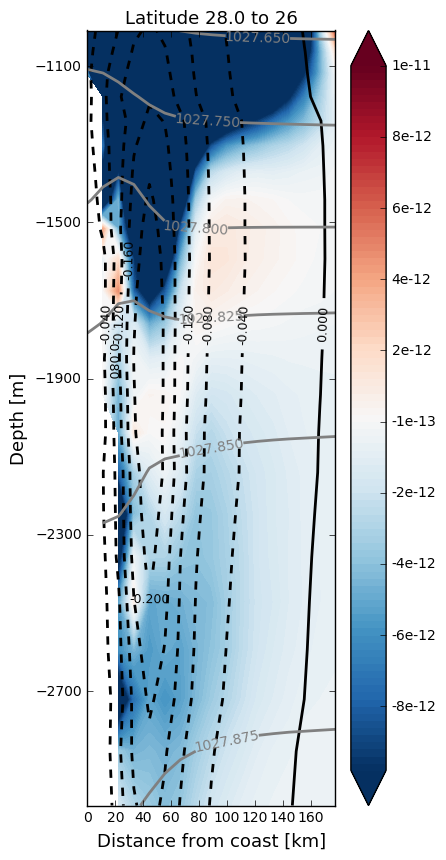

In [106]:
fig=plt.figure(figsize=(4,10))
#a=fig.add_subplot(111,axisbg='grey')
plt.title("Latitude " + str(lat_from) + " to " + str( lat_to ),fontsize=13)
plt.xlabel("Distance from coast [km]",fontsize=13)
plt.ylabel("Depth [m]",fontsize=13)
plt.yticks([-1100,-1500,-1900,-2300,-2700,-3100])
high=1.e-11
#high=0.9e-8
fvke = plt.contour(x, -z, data_upar, 6,colors='k', linewidths=2)  # negative contours will be dashed by default
plt.clabel(fvke, fontsize=9, inline=1)
v =  np.linspace(-high,high,100)
w = (1027.5,1027.65,1027.75,1027.8,1027.825,1027.85,1027.875)
frho = plt.contour(x,-z,data_rho, w, colors='grey', linewidths=2)
plt.clabel(frho, fontsize=10, inline=1,colors="grey",styles="oblique")

fdiv=plt.contourf(x,-z,data_Pe2Pm_hor,v,extend="both")
#plt.contourf(x,-z,data_divUrho,100)
cbar =plt.colorbar(format='%.0e',orientation="vertical")
plt.set_cmap("RdBu_r")
plt.show()

## Fluxes in xz-plain

plt.figure(figsize=(30,20))
if case == "10S":
    plt.suptitle("Eddy Fluxes 10S-18S",fontsize=30)
if case == "11N":
    plt.suptitle("Eddy Fluxes 11N-18N",fontsize=30)
plt.subplot(311)
v = np.linspace(-0.0007,0.0007,100)
plt.contourf(x,-z,data_upar_eddy[:,:],v,extend="both")
plt.title("Along stream eddy flux",fontsize=25)
cbar=plt.colorbar(format='%.0e')
cbar.ax.tick_params(labelsize=25) 
plt.subplot(312)
v = np.linspace(-0.0002,0.0002,100)
plt.contourf(x,-z,data_uper_eddy[:,:],v,extend="both")
plt.title("Across stream eddy flux",fontsize=25)
cbar=plt.colorbar(format='%.0e')
cbar.ax.tick_params(labelsize=25) 
plt.subplot(313)
v = np.linspace(-0.0000005,0.0000005,100)
plt.contourf(x,-z,data_wrho_eddy[:,:],v,extend="both")
plt.title("Vertical eddy flux",fontsize=25)

cbar=plt.colorbar(format='%.0e')
cbar.ax.tick_params(labelsize=25) 
if case == "10S":
    plt.savefig("eddy_fluxes_10S-18S.png")
if case == "11N":
    plt.savefig("eddy_fluxes_11N-18N.png")
plt.show()

## Compute Stream function

plt.figure(figsize=(10,10))
v =  np.linspace(-0.0008,0.0008,100)
plt.subplot(211)
plt.contourf(lon2,lat2,vrho_eddy2[55,:,:],v,extend="both")
plt.colorbar(format='%.0e')
plt.subplot(212)
plt.contourf(lon2,lat2,urho_eddy2[55,:,:],v,extend="both")
plt.colorbar(format='%.0e')
plt.show()

plt.contourf(data_rho)
plt.colorbar()
plt.show()